In [1]:
# Copyright 2021 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<img src="http://developer.download.nvidia.com/compute/machine-learning/frameworks/nvidia_logo.png" style="width: 90px; float: right;">

# Transformers4Rec demo: 
<h2><center> Train a Session-based recommender with Yoochoose e-commerce dataset using  XLNET </center></h2>


## 1. Import Libraries and Define Data Input and Output Paths

In [2]:
import glob
import numpy as np
import os

import cudf
import cupy
import nvtabular as nvt

In [3]:
DATA_FOLDER = "/workspace/data/"
FILENAME_PATTERN = 'yoochoose-clicks.dat'
DATA_PATH = os.path.join(DATA_FOLDER, FILENAME_PATTERN)

OUTPUT_FOLDER = "./yoochoose_transformed"
OVERWRITE = False

### 1.1. Load and clean raw data

In this notebook we are using the `YOOCHOOSE dataset` which contains a collection of sessions from a retailer, where each session is encapsulating the click events that the user performed in that session.

The dataset is available on [Kaggle](https://www.kaggle.com/chadgostopp/recsys-challenge-2015). Note that we are using the file `yoochoose-clicks.dat`


In [4]:
interactions_df = cudf.read_csv(DATA_PATH, sep=',', 
                                names=['session_id','timestamp', 'item_id', 'category'], 
                                dtype=['int', 'datetime64[s]', 'int', 'int'])

    1- Remove repeated interactions within the same session

In [5]:
print("Count with in-session repeated interactions: {}".format(len(interactions_df)))
# Sorts the dataframe by session and timestamp, to remove consecutive repetitions
interactions_df.timestamp = interactions_df.timestamp.astype(int)
interactions_df = interactions_df.sort_values(['session_id', 'timestamp'])
past_ids = interactions_df['item_id'].shift(1).fillna()
session_past_ids = interactions_df['session_id'].shift(1).fillna()
# Keeping only no consectutive repeated in session interactions
interactions_df = interactions_df[~((interactions_df['session_id'] == session_past_ids) & (interactions_df['item_id'] == past_ids))]
print("Count after removed in-session repeated interactions: {}".format(len(interactions_df)))

Count with in-session repeated interactions: 33003944
Count after removed in-session repeated interactions: 28971543


    2- Create date when item was seen for the first-time  

In [6]:
items_first_ts_df = interactions_df.groupby('item_id').agg({'timestamp': 'min'}).reset_index().rename(columns={'timestamp': 'itemid_ts_first'})
interactions_merged_df = interactions_df.merge(items_first_ts_df, on=['item_id'], how='left')
interactions_merged_df.head()

,session_id,timestamp,item_id,category,itemid_ts_first
0,549,1396774534,214714927,0,1396334996
1,549,1396774556,214517450,0,1396329825
2,549,1396774617,214714929,0,1396341783
3,549,1396774647,214518555,0,1396327272
4,549,1396774664,214639297,0,1396353119


In [7]:
# free gpu memory
import gc
del interactions_df, session_past_ids, items_first_ts_df
gc.collect()

0

## 2. Define NVTabular Workflow

NVTabular is a feature engineering and preprocessing library for tabular data designed to quickly and easily manipulate terabyte scale datasets used to train deep learning based recommender systems. It provides a high level abstraction to simplify code and accelerates computation on the GPU using the RAPIDS cuDF library.

NVTabular supports different feature engineering transformations required by Deep Learning models such as Categroical encoding and numerical feature normalization. It also supports session-based feature engineering such as the creation of lists via grouping by operations and list slicing. 

More information about the supported features can be found <a href=https://nvidia.github.io/NVTabular/main/index.html> here. </a>

### 2.1 Feature engineering: Create and Transform items features

In this cell, we are defining three transformations ops: 

    1- Encoding categorical variables using Categorify() op.
    2- Deriving temporal features from timestamp and computing their cyclical representation using a custom lambda function. 
    3- Computing the item recency in days using a custom Op. We note that item recency is defined as the difference between the first occurence of the item in dataset and the actual date of item interaction. 

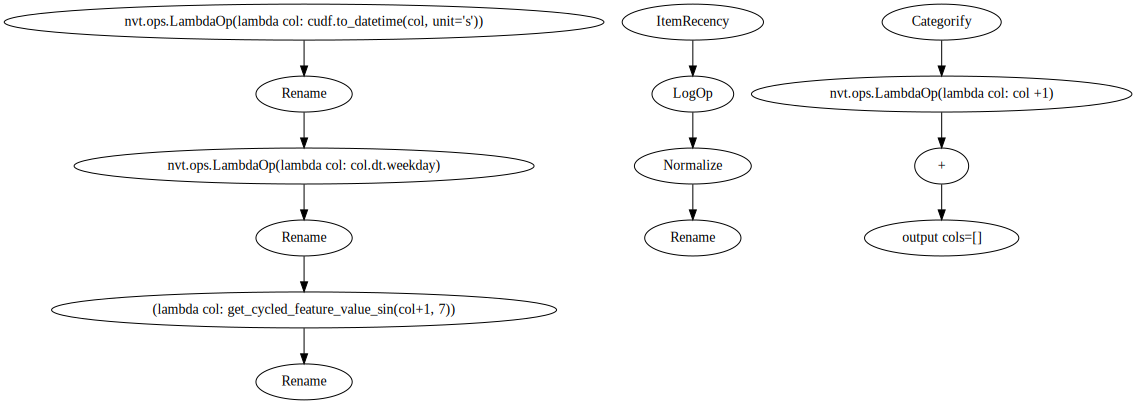

In [7]:
# categorify features 
cat_feats = nvt.ColumnSelector(['session_id', 'category', 'item_id']) >> nvt.ops.Categorify() >> nvt.ops.LambdaOp(lambda col: col +1)

# create time features
sessionTs = nvt.ColumnSelector(['timestamp'])
sessionTime = (
    sessionTs >> 
    nvt.ops.LambdaOp(lambda col: cudf.to_datetime(col, unit='s')) >> 
    nvt.ops.Rename(name = 'event_time_dt')
)
sessionTime_weekday = (
    sessionTime >> 
    nvt.ops.LambdaOp(lambda col: col.dt.weekday) >> 
    nvt.ops.Rename(name ='et_dayofweek')
)

# Derive cyclical features : Define custom lambda function 
def get_cycled_feature_value_sin(col, max_value):
    value_scaled = (col + 0.000001) / max_value
    value_sin = np.sin(2*np.pi*value_scaled)
    return value_sin

weekday_sin = sessionTime_weekday >> (lambda col: get_cycled_feature_value_sin(col+1, 7)) >> nvt.ops.Rename(name = 'et_dayofweek_sin')

# Compute Item recency : Define custom operator 
class ItemRecency(nvt.ops.Operator):
    def transform(self, columns, gdf):
        for column in columns.names:
            col = gdf[column]
            item_first_timestamp = gdf['itemid_ts_first']
            delta_days = (col - item_first_timestamp) / (60*60*24)
            gdf[column + "_age_days"] = delta_days * (delta_days >=0)
        return gdf
           
    def output_column_names(self, columns):
        return nvt.ColumnSelector([column + "_age_days" for column in columns.names])

    def dependencies(self):
        return ["itemid_ts_first"]
    

recency_features = sessionTs >> ItemRecency() 
recency_features_norm = recency_features >> nvt.ops.LogOp() >> nvt.ops.Normalize() >> nvt.ops.Rename(name='product_recency_days_log_norm')


time_features = (
    sessionTime +
    sessionTime_weekday +
    weekday_sin + 
    recency_features_norm
)

features = nvt.ColumnSelector(['timestamp', 'session_id']) + cat_feats + time_features 
features.graph

### 2.2 Generate session-based features

Once the item features are generated, the objective of this cell is grouping them together at the session level, sorting the interactions by time. We additionnaly truncate all sessions to first 20 interactions and filtered out sessions with less than 2 interactions.


In [8]:
# Define Groupby Operator
groupby_features = features >> nvt.ops.Groupby(
    groupby_cols=["session_id"], 
    sort_cols=["timestamp"],
    aggs={
        'item_id': ["list", "count"],
        'category': ["list"],  
        'timestamp': ["first"],
        'event_time_dt': ["first"],
        'et_dayofweek_sin': ["list"],
        'product_recency_days_log_norm': ["list"]
        },
    name_sep="-")


# Truncate sequence features to first interacted 20 items 
SESSIONS_MAX_LENGTH = 20 

groupby_features_list = groupby_features['item_id-list', 'category-list', 'et_dayofweek_sin-list', 'product_recency_days_log_norm-list']
groupby_features_trim = groupby_features_list >> nvt.ops.ListSlice(0, SESSIONS_MAX_LENGTH) >> nvt.ops.Rename(postfix = '_seq')

# calculate session day index based on 'event_time_dt-first' column
day_index = ((groupby_features['event_time_dt-first'])  >> 
    nvt.ops.LambdaOp(lambda col: (col - col.min()).dt.days +1) >> 
    nvt.ops.Rename(f = lambda col: "day_index")
)

# Select features for training 
selected_features = groupby_features['session_id', 'item_id-count'] + groupby_features_trim + day_index

# Filter out sessions with less than 2 interactions 
MINIMUM_SESSION_LENGTH = 2
filtered_sessions = selected_features >> nvt.ops.Filter(f=lambda df: df["item_id-count"] >= MINIMUM_SESSION_LENGTH) 


### 2.3 Execute NVTabular workflow

Once we have defined the general workflow `filtered_sessions`, we provide our cudf dataset to nvt.Dataset class which is optimized to split data into chunks that can fit in device memory and to handle the calculation of complex global statistics. Then, we execute the pipeline that fits and transforms data to get the desired output features.

In [9]:
dataset = nvt.Dataset(interactions_merged_df)
workflow = nvt.Workflow(filtered_sessions)
workflow.fit(dataset)
sessions_gdf = workflow.transform(dataset).compute()

/usr/local/lib/python3.8/dist-packages/numba/cuda/compiler.py:865: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (160) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [10]:
sessions_gdf.head()

,session_id,item_id-count,item_id-list_seq,category-list_seq,et_dayofweek_sin-list_seq,product_recency_days_log_norm-list_seq,day_index
0,2,200,"[2223, 2125, 1800, 123, 3030, 1861, 1076, 1285...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[1.1285199e-06, 1.1285199e-06, 1.1285199e-06, ...","[-1.1126341, -0.9665389, -0.1350116, -0.127809...",27
1,3,200,"[26562, 35137, 19260, 46449, 29027, 39096, 272...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0.43388295, 0.43388295, 0.43388295, 0.4338829...","[0.40848607, 0.39331725, 0.5418466, -3.0278225...",58
2,4,200,"[23212, 30448, 16468, 2052, 22490, 31097, 6243...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0.9749277, 0.9749277, 0.9749277, 0.9749277, 0...","[0.6801631, 0.7174695, 0.7185285, 0.7204116, 0...",71
3,5,200,"[230, 451, 732, 1268, 2014, 567, 497, 439, 338...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, ...","[0.43388295, 0.43388295, 0.43388295, 0.4338829...","[1.3680888, -0.6530481, -0.69314253, -0.590593...",149
4,6,200,"[23, 70, 160, 70, 90, 742, 851, 359, 734, 878,...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0.43388295, 0.43388295, 0.43388295, 0.4338829...","[1.3714824, 1.3715883, 1.3715737, 1.3715955, 1...",149


**Save the workflow**

In [11]:
workflow.save('workflow_etl')

### 2.4 Export pre-processed data by day

  - For daily training we need to partition data by day, create the Train/Validation/Test splits and save them to disk using day-index column. 
  
  
  - It is worthwhile to note that the dataset have a single categorical feature (category), but it is inconsistent over time in the dataset. All interactions before day 84 (2014-06-23) have the same value for that feature, whereas many other categories are introduced afterwards. 
  
  
  - For the purpose of the demo, we only save the last five days.

In [12]:
sessions_gdf = sessions_gdf[sessions_gdf.day_index>=178]

In [13]:
from transformers4rec.utils.gpu_preprocessing import save_time_based_splits
save_time_based_splits(data=nvt.Dataset(sessions_gdf),
                       output_dir= "./preproc_sessions_by_day",
                       partition_col='day_index',
                       timestamp_col='session_id', 
                      )

Creating time-based splits: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


In [14]:
from demo_utils import list_files
list_files('./preproc_sessions_by_day')

preproc_sessions_by_day_ts/
    180/
        test.parquet
        valid.parquet
        train.parquet
    181/
        test.parquet
        valid.parquet
        train.parquet
    179/
        test.parquet
        valid.parquet
        train.parquet
    182/
        test.parquet
        valid.parquet
        train.parquet
    178/
        test.parquet
        valid.parquet
        train.parquet


In [15]:
# free gpu memory
del  sessions_gdf
gc.collect()

255

## 3. Model definition using Transformers4Rec

### 3.1 Get the schema 

The library uses a schema format to configure the input features and automatically creates the necessary layers. This proto text file contains the description of each input feature by defining : The name, the type, the number of elements of a list column,  the cardinality of a categorical feature and the min and max values of a continuous varable. In addition, the annotation field contains the tags to allow custom annotation such as specifying the `target` column or the `item` features.

In [39]:
from merlin_standard_lib import Schema
SCHEMA_PATH = "schema_demo.pb"
schema = Schema().from_proto_text(SCHEMA_PATH)
!head -20 $SCHEMA_PATH

feature {
  name: "item_id-list_seq"
  value_count {
    min: 2
    max: 185
  }
  type: INT
  int_domain {
    name: "item_id/list"
    min: 1
    max: 52742
    is_categorical: true
  }
  annotation {
    tag: "item_id"
    tag: "list"
    tag: "categorical"
    tag: "item"
  }
}


We can select the subset of features we want to use for training the model by their tags or their names.

In [40]:
schema = schema.select_by_tag('item')

In [42]:
schema = schema.select_by_name(
   ['item_id-list_seq', 'category-list_seq', 'product_recency_days_log_norm-list_seq', 'et_dayofweek_sin-list_seq']
)

### 3.2 Define the end-to-end Session-based Transformer-based recommendation model

For session-based recommendation model definition, the end-to-end model definition requires four steps:

1. Instantiate `TabularSequenceFeatures` input-module from schema to prepare the embedding tables of categorical variables and project continuous features, if specified. In addition the module provides different aggregation methods to merge input features and generate the sequence of interactions embeddings. The module also supports language modeling tasks to prepare masked labels for training and evaluation (e.g: 'causal' for causal language modeling) 

2. Next, we need to define one or multiple prediction tasks. For this demo, we are going to use `NextItemPredictionTask`: during training the next item or randomly selected items are predicted depending on the masking scheme. For inference it is meant to always predict the next item to be interacted with.

3. Then we construct a `transformer_config` based on the architectures provided by [Hugging Face Transformers](https://github.com/huggingface/transformers) framework. </a>

4. Finally we link the transformer-body to the inputs and the prediction tasks to get the final pytorch `Model` class.
    
For more details about the features supported by each sub-module, please check the `Core Features` <a href=https://github.com/NVIDIA-Merlin/Transformers4Rec/blob/main/docs/source/core_features.md> documentation page </a>.

In [18]:
from transformers4rec import torch as tr

max_sequence_length, d_model = 20, 320
# Define input module to process tabular input-features and to prepare masked inputs
input_module = tr.TabularSequenceFeatures.from_schema(
    schema,
    max_sequence_length=max_sequence_length,
    continuous_projection=64,
    aggregation="concat",
    d_output=d_model,
    masking="mlm",
)

# Define Next item prediction-task 
prediction_task = tr.NextItemPredictionTask(hf_format=True, weight_tying=True)

# Define the config of the XLNet Transformer architecture
transformer_config = tr.XLNetConfig.build(
    d_model=d_model, n_head=8, n_layer=2, total_seq_length=max_sequence_length
)

#Get the end-to-end model 
model = transformer_config.to_torch_model(input_module, prediction_task)

Projecting inputs of NextItemPredictionTask to'64' As weight tying requires the input dimension '320' to be equal to the item-id embedding dimension '64'


In [19]:
model

Model(
  (heads): ModuleList(
    (0): Head(
      (body): SequentialBlock(
        (0): TabularSequenceFeatures(
          (_aggregation): ConcatFeatures()
          (to_merge): ModuleDict(
            (continuous_module): SequentialBlock(
              (0): ContinuousFeatures(
                (filter_features): FilterFeatures()
                (_aggregation): ConcatFeatures()
              )
              (1): SequentialBlock(
                (0): DenseBlock(
                  (0): Linear(in_features=1, out_features=64, bias=True)
                  (1): ReLU(inplace=True)
                )
              )
              (2): AsTabular()
            )
            (categorical_module): SequenceEmbeddingFeatures(
              (filter_features): FilterFeatures()
              (embedding_tables): ModuleDict(
                (item_id-list_seq): Embedding(52743, 64, padding_idx=0)
                (category-list_seq): Embedding(338, 64, padding_idx=0)
              )
            )
          

### 3.3. Daily Fine-Tuning: Training over a time window¶

Now that the model is defined, we are going to launch training. For that, Transfromers4rec extends HF Transformers Trainer class to adapt the evaluation loop for session-based recommendation task and the calculation of ranking metrics. The original train() method is not modified meaning that we leverage the efficient training implementation from that library, which manages for example half-precision (FP16) training.

- **Set Training arguments**

An additional argument `data_loader_engine` is defined to automatically load the features needed for training using the schema. The default value is `nvtabular` for optimized GPU-based data-loading.  Optionally the PyarrowDataLoader (`pyarrow`) can also be used as a basic option, but it is slower and works only for small datasets, as the full data is loaded to CPU memory.

In [20]:
training_args = tr.trainer.T4RecTrainingArguments(
            output_dir="./tmp",
            max_sequence_length=20,
            data_loader_engine='nvtabular',
            num_train_epochs=10, 
            dataloader_drop_last=False,
            per_device_train_batch_size = 384,
            per_device_eval_batch_size = 512,
            learning_rate=0.0005,
            fp16=True,
            report_to = [],
            logging_steps=200
        )

* **Instantiate the trainer** 

In [30]:
recsys_trainer = tr.Trainer(
    model=model,
    args=training_args,
    schema=schema,
    compute_metrics=True)

Using amp fp16 backend


* **Launch daily Training and Evaluation:** 

In this demo, we will use the `fit_and_evaluate` method that allows us to conduct a time-based finetuning by iteratively training and evaluating using a sliding time window: At each iteration, we use training data of a specific time index $t$ to train the model then we evaluate on the validation data of next index $t + 1$. Particularly, the start time is set to 178 and end time to 180.

In [35]:
def fit_and_evaluate(trainer, start_time_index, end_time_index, input_dir='./preproc_sessions_by_day'):
    """
    Util function for time-window based fine-tuning using the T4rec Trainer class. 
    Iteratively train using data of a given index and evaluate on the validation data
    of the following index.

    Parameters
    ----------
    start_time_index: int
        the start index for training, it should match the partitions of the data directory 
    end_time_index: int
        the end index for training, it should match the partitions of the  data directory 
    input_dir: str
        The input directory where the parquet files were saved based on partition column
    
    Returns
    -------
    aot_metrics: dict
        The average over time of ranking metrics.
    """
    import glob
    import os
    aot_metrics = {}
    for time_index in range(start_time_index, end_time_index+1):
        # 1. Set data 
        time_index_train = time_index
        time_index_eval = time_index + 1
        train_paths = glob.glob(os.path.join(input_dir, f"{time_index_train}/train.parquet"))
        eval_paths = glob.glob(os.path.join(input_dir, f"{time_index_eval}/valid.parquet")) 

        # 2. Train on day related to time_index 
        print("\n***** Launch training for day %s: *****" %time_index)
        trainer.train_dataset_or_path = train_paths
        trainer.reset_lr_scheduler()
        trainer.train()
        trainer.state.global_step +=1

        # 3. Evaluate on the following day
        trainer.eval_dataset_or_path = eval_paths
        eval_metrics = trainer.evaluate(metric_key_prefix='eval')
        print("\n***** Evaluation results for day %s:*****\n" %time_index_eval)
        for key in sorted(eval_metrics.keys()):
            if 'at_' in key: 
                print(" %s = %s" % (key.replace('at_', '@'), str(eval_metrics[key]))) 
                if 'AOT_'+key.replace('at_', '@') in aot_metrics: 
                    aot_metrics['AOT_'+key.replace('_at_', '@')] += [eval_metrics[key]]
                else: 
                    aot_metrics['AOT_'+key.replace('_at_', '@')] = [eval_metrics[key]]

        # free GPU for next day training 
        trainer.wipe_memory()

    return aot_metrics

In [36]:
aot_results = fit_and_evaluate(recsys_trainer, start_time_index=178, end_time_index=178, input_dir='./preproc_sessions_by_day')

***** Running training *****
  Num examples = 28800
  Num Epochs = 10
  Instantaneous batch size per device = 384
  Total train batch size (w. parallel, distributed & accumulation) = 384
  Gradient Accumulation steps = 1
  Total optimization steps = 750



***** Launch training for day 178: *****


Step,Training Loss
200,5.491200
400,5.317000
600,5.187700


Saving model checkpoint to ./tmp/checkpoint-500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)





***** Evaluation results for day 179:*****

 eval/next-item/avg_precision_@10 = 0.14822982251644135
 eval/next-item/avg_precision_@20 = 0.15453767776489258
 eval/next-item/ndcg_@10 = 0.190110981464386
 eval/next-item/ndcg_@20 = 0.21371710300445557
 eval/next-item/recall_@10 = 0.3240847885608673
 eval/next-item/recall_@20 = 0.4161849617958069


* **Visualize the average over time metrics**

In [34]:
mean_results = {k: np.mean(v) for k,v in aot_results.items()}
for key in sorted(mean_results.keys()): 
    print(" %s = %s" % (key, str(mean_results[key]))) 

 AOT_eval/next-item/avg_precision@10 = 0.13518714904785156
 AOT_eval/next-item/avg_precision@20 = 0.1435002237558365
 AOT_eval/next-item/ndcg@10 = 0.17796631157398224
 AOT_eval/next-item/ndcg@20 = 0.20810143649578094
 AOT_eval/next-item/recall@10 = 0.3126159608364105
 AOT_eval/next-item/recall@20 = 0.4304267168045044


* **Save the model**

In [24]:
recsys_trainer._save_model_and_checkpoint(save_model_class=True)

Saving model checkpoint to ./tmp/checkpoint-751
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


- **Export the worflow and model in the format required by Triton server:** 

NVTabular’s `export_pytorch_ensemble` function enables us to create model files and config files to be served to Triton Inference Server. 

In [25]:
from nvtabular.inference.triton import export_pytorch_ensemble
export_pytorch_ensemble(
    model,
    workflow,
    sparse_max=recsys_trainer.get_train_dataloader().dataset.sparse_max,
    name= "t4r_pytorch",
    model_path= "/workspace/models/",
    label_columns =[],
)

## 4. Serving Ensemble Model to the Triton Inference Server

At this point, before connecing to the Triton Server, we launch the inference docker container and then load the ensemble `t4r_pytorch` to the inference server. This is done with the scripts below:

**launch the docker container:**<br>
```
docker run -it --gpus device=0 -p 8000:8000 -p 8001:8001 -p 8002:8002 -v <path_to_saved_models>:/root/models/ nvcr.io/nvidia/merlin/merlin-inference:0.6
```
This script will mount your local model-repository folder that includes your saved models from the previous cell to `/root/models` directory in the merlin-inference docker container.

**start triton server:**<br>
After you started the merlin-inference container, you can start triton server with the command below. You need to provide correct path of the models folder.


```
tritonserver --model-repository=<path_to_models> --model-control-mode=explicit
```
Note: The model-repository path for our example is `/root/models`. The models haven't been loaded, yet. Below, we will request the Triton server to load the saved ensemble model below.

- Connect to the Triton Inference Server and check if the server is alive

In [7]:
import tritonhttpclient
try:
    triton_client = tritonhttpclient.InferenceServerClient(url="localhost:8000", verbose=True)
    print("client created.")
except Exception as e:
    print("channel creation failed: " + str(e))
triton_client.is_server_live()

client created.
GET /v2/health/live, headers None
<HTTPSocketPoolResponse status=200 headers={'content-length': '0', 'content-type': 'text/plain'}>


/usr/local/lib/python3.8/dist-packages/tritonhttpclient/__init__.py:31: DeprecationWarning: The package `tritonhttpclient` is deprecated and will be removed in a future version. Please use instead `tritonclient.http`
  warnings.warn(


True

- Load raw data for inference: We select the last 50 interactions and filter out sessions with less than 2 interactions 

In [8]:
interactions_merged_df=interactions_merged_df.sort_values('timestamp')
batch = interactions_merged_df[-50:]
sessions_to_use = batch.session_id.value_counts()[batch.session_id.value_counts() > 1].index.values
filtered_batch = batch[batch.session_id.isin(sessions_to_use)]

- Send the request to triton server

In [13]:
triton_client.get_model_repository_index()

POST /v2/repository/index, headers None

<HTTPSocketPoolResponse status=200 headers={'content-type': 'application/json', 'content-length': '77'}>
bytearray(b'[{"name":"t4r_pytorch"},{"name":"t4r_pytorch_nvt"},{"name":"t4r_pytorch_pt"}]')


[{'name': 't4r_pytorch'},
 {'name': 't4r_pytorch_nvt'},
 {'name': 't4r_pytorch_pt'}]

- Load the ensemble model to triton: If all models are loaded succesfully, you should be seeing `successfully loaded` status next to each model name on your terminal.

In [15]:
triton_client.load_model(model_name="t4r_pytorch")

POST /v2/repository/models/t4r_pytorch/load, headers None

<HTTPSocketPoolResponse status=200 headers={'content-type': 'application/json', 'content-length': '0'}>
Loaded model 't4r_pytorch'


In [16]:
import nvtabular.inference.triton as nvt_triton
import tritonclient.grpc as grpcclient

inputs = nvt_triton.convert_df_to_triton_input(filtered_batch.columns, filtered_batch, grpcclient.InferInput)

output_names = ["output"]

outputs = []
for col in output_names:
    outputs.append(grpcclient.InferRequestedOutput(col))
    
MODEL_NAME_NVT = "t4r_pytorch"

with grpcclient.InferenceServerClient("localhost:8001") as client:
    response = client.infer(MODEL_NAME_NVT, inputs)
    print(col, ':\n', response.as_numpy(col))

output :
 [[-24.15944   -27.404991   -4.94611   ... -22.49609   -24.682003
  -25.877012 ]
 [-15.90125   -15.065917   -6.661085  ... -15.156942  -15.099242
  -15.492717 ]
 [-17.890999  -18.058104   -6.7184315 ... -17.763319  -17.483799
  -18.03847  ]
 ...
 [-21.916159  -24.027723   -5.6256742 ... -22.193144  -23.233112
  -24.193878 ]
 [-21.491413  -24.481197   -5.6657963 ... -22.603016  -22.793688
  -24.614845 ]
 [-21.478308  -23.406733   -5.571887  ... -21.498636  -22.689898
  -23.32546  ]]


- Visualise top-k predictions

In [17]:
from demo_utils import visualize_response
visualize_response(filtered_batch, response, top_k=5)

- Top-5 predictions for session `11257991`: 88 || 302 || 93 || 289 || 166

- Top-5 predictions for session `11270119`: 2774 || 81 || 157 || 224 || 2814

- Top-5 predictions for session `11311424`: 2788 || 2214 || 157 || 620 || 633

- Top-5 predictions for session `11336059`: 475 || 1987 || 1085 || 597 || 633

- Top-5 predictions for session `11394056`: 224 || 2814 || 2789 || 53 || 157

- Top-5 predictions for session `11399751`: 1453 || 1219 || 620 || 157 || 633

- Top-5 predictions for session `11401481`: 224 || 633 || 157 || 620 || 2788

- Top-5 predictions for session `11421333`: 836 || 1020 || 612 || 1169 || 51

- Top-5 predictions for session `11425751`: 633 || 2214 || 2556 || 224 || 157

- Top-5 predictions for session `11445777`: 206 || 804 || 442 || 184 || 33

- Top-5 predictions for session `11457123`: 2 || 804 || 442 || 184 || 33

- Top-5 predictions for session `11467406`: 620 || 2651 || 224 || 157 || 2788

- Top-5 predictions for session `11493827`: 1756 || 206 || 33 || 61 

## References

- Merlin Transformers4rec: https://github.com/NVIDIA-Merlin/Transformers4Rec

- Merlin NVTabular: https://github.com/NVIDIA/NVTabular/tree/main/nvtabular

- Triton inference server: https://github.com/triton-inference-server